In [102]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import *
import datetime as dt
from datetime import datetime as dte
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,confusion_matrix, r2_score, mean_absolute_error
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae

import re
import sqlalchemy as sa
import json
import joblib

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split


from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split

In [103]:
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500
pd.options.display.max_categories = 500
pd.set_option("display.max_rows", None)

# Execution Time

In [104]:
print(f'Execution Time = {dt.datetime.now()}')

Execution Time = 2022-12-13 17:00:24.607090


In [105]:
inject_params_dict = ""

inject_params_dict = {'program_name':'Box3d','mode':'retrain','target':'revenue', 'other_models':True,
                      'current_wd':'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model'}

### Mode's 
##### 1. retrain
##### 2. retrain_with_gridsearch
##### 3. predict

In [106]:
mode = inject_params_dict['mode']
target = inject_params_dict['target']
program_name = inject_params_dict['program_name']
current_wd = inject_params_dict['current_wd']
other_models = inject_params_dict['other_models']
print("Run Mode: ",mode)
print("Target Variable: ",target)
print("Program Name: ",program_name)

Run Mode:  retrain
Target Variable:  revenue
Program Name:  Box3d


In [107]:
os.chdir(current_wd)
%run Utilities.ipynb

In [108]:
script_run  =  mode    # predict #retrain_with_gridsearch #retrain
target      = target #churn_trueup_mrc_7day
targettype  = 'continuous'

### Retrain:

### Predict:

In [109]:
os.chdir(current_wd)
print(os.getcwd())

C:\Users\simranpal.kohli\AAAAAfiniti\Personal\Self_Study\Projectzzz\Hashmeet_Friend\Aman_Project\Churn_Model


# Configurations Passed:

In [110]:
unique_identifier = ['id'] #list of columns that makeup primary key
smalls_threshold_percent = 1.0 #less <=smalls_threshold_percent binned to small
numeric_correlation_threshold = 0.8
cat_correlation_threshold = 0.80
top_k = 75 #percentage of top features to pick
plot_granularity = 'date' # week, date

In [111]:
# Configurations Print
print('script_run = ' , script_run)
print('target = ' ,     target)
print('targettype = ' , targettype)

script_run =  retrain
target =  revenue
targettype =  continuous


In [112]:
prefix = 'best'
Data_Files_ls = os.listdir(f'{os.getcwd()}/{program_name}/Data_Files/')
pkl_file_name = [files for files in Data_Files_ls if files.startswith(prefix)]
last_trained_model_date = pkl_file_name[0].split('.')[0][-10:]
print('Last train model date: ',last_trained_model_date)

Last train model date:  2022_12_13


In [113]:
if script_run in ['retrain','retrain_with_gridsearch']:
    today_trained_model_date = dte.today().strftime('%Y-%m-%d').replace('-','_')
    
    Data_Files_ls = os.listdir(f'{os.getcwd()}/{program_name}/Data_Files/')
    for f in Data_Files_ls:
        if not f.startswith('.'):
            shutil.copyfile(f'{os.getcwd()}/{program_name}/Data_Files/{f}',f'{os.getcwd()}/{program_name}/Data_Files_Old/{f}')
    model_name_new  = program_name +'_'+today_trained_model_date+'_' + target #retrain after 1-2 weeks
    print("Model Name New: ",model_name_new)
    
model_name  = program_name +'_'+last_trained_model_date+'_' + target #retrain after 1-2 weeks
print("Model Name Old: ",model_name)

Model Name New:  Box3d_2022_12_13_revenue
Model Name Old:  Box3d_2022_12_13_revenue


In [114]:
if script_run in ['retrain','retrain_with_gridsearch']:
    data_raw = pd.read_csv('Dataset/train.csv')
if script_run == 'predict':
    data_raw = pd.read_csv("Dataset/test.csv")
    pred_raw = data_raw.copy()
data_raw.columns = [x.lower() for x in data_raw.columns] 

In [115]:
data_raw.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.58,...,2/20/15,93.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.25,...,8/6/04,113.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.30,...,10/10/14,105.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.17,...,3/9/12,122.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.15,...,2/5/09,118.00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [116]:
data_raw.describe()

,id,budget,popularity,runtime,revenue
count,3000.00,3000.00,3000.00,2998.00,3000.00
mean,1500.50,22531334.11,8.46,107.86,66725851.89
std,866.17,37026086.41,12.10,22.09,137532326.34
min,1.00,0.00,0.00,0.00,1.00
25%,750.75,0.00,4.02,94.00,2379808.25
50%,1500.50,8000000.00,7.37,104.00,16807068.00
75%,2250.25,29000000.00,10.89,118.00,68919203.50
max,3000.00,380000000.00,294.34,338.00,1519557910.00


## Dropping Features with most NULL counts

In [117]:
NULLsRecords = data_raw.isnull().sum(axis=0)
print(NULLsRecords[NULLsRecords>0])
max(NULLsRecords)

belongs_to_collection    2396
genres                      7
homepage                 2054
overview                    8
poster_path                 1
production_companies      156
production_countries       55
runtime                     2
spoken_languages           20
tagline                   597
keywords                  276
cast                       13
crew                       16
dtype: int64


2396

In [118]:
data_raw.drop(['belongs_to_collection'], axis=1, inplace=True)
data_raw.drop(['homepage'], axis=1, inplace=True)

# Budget Metric & its Distribution:

In [119]:
data_raw['release_date'] = pd.to_datetime(data_raw['release_date'],errors='coerce')
data_raw['date'] = pd.to_datetime(data_raw['release_date'],errors='coerce')
data_raw['date'] = data_raw['date'].dt.date
data_raw['week'] = data_raw['release_date'].dt.isocalendar().year * 52 + data_raw['release_date'].dt.isocalendar().week

0 records in data where target is NA 



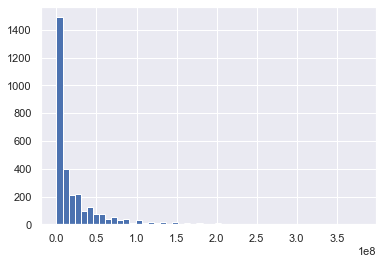

In [120]:
#Data Preprocessing & Distribtuion of Budget Metric
na_target = data_raw[data_raw['budget'].isna()]
if na_target.shape[0]>=0:
    print(f'{na_target.shape[0]} records in data where target is NA \n')
    data_raw = data_raw.dropna(axis = 0, subset=['budget'])        
    %matplotlib inline
    data_raw['budget'].hist(bins=50)
    plt.show()

## Manually Clipping Budget
Make a table with weekwise 1st and 99th quantiles as sanity check for `groupby` operation

In [121]:
weekly_quantiles = data_raw.groupby('week')['budget'].quantile([0.01, 0.99]).reset_index()
weekly_quantiles = weekly_quantiles.pivot(index = 'week', columns = 'level_1').reset_index()
weekly_quantiles.columns = weekly_quantiles.columns.to_flat_index()
weekly_quantiles.columns = [
    'week', 
    'budget' + '_' + str(0.01), 
    'budget' + '_' + str(0.99)
]
weekly_quantiles.head()

,week,budget_0.01,budget_0.99
0,102546,6000000.00,6000000.00
1,102551,410000.00,410000.00
2,102554,12000.00,12000.00
3,102555,6000000.00,6000000.00
4,102570,1700000.00,1700000.00


In [122]:
def clip_series(s, lower, upper):
    clipped = s.clip(lower = s.quantile(lower), upper = s.quantile(upper))
    return clipped

clipped_target = data_raw.groupby('week')['budget'].apply(clip_series, lower = 0.01, upper = 0.99)

In [123]:
data_raw['clipped_budget'] = clipped_target

In [124]:
# Clipping should not create NAs in target metric
assert data_raw['budget'].isna().sum() == 0

In [125]:
# Examine summary statistics to confirm in and max have been clipped
data_raw[['budget', 'clipped_budget']].describe()

,budget,clipped_budget
count,3000.00,3000.00
mean,22531334.11,22437580.62
std,37026086.41,36592021.88
min,0.00,0.00
25%,0.00,250000.00
50%,8000000.00,8000000.00
75%,29000000.00,28475000.00
max,380000000.00,369500000.00


0 records in data where target is NA 



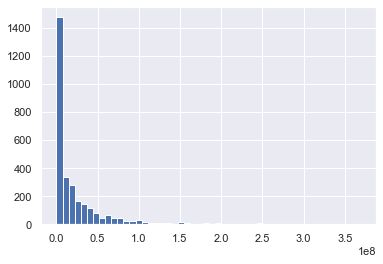

In [126]:
#Data Preprocessing & Distribtuion of Target Metric
na_target = data_raw[data_raw['clipped_budget'].isna()]
if na_target.shape[0]>=0:
    print(f'{na_target.shape[0]} records in data where target is NA \n')
    data_raw = data_raw.dropna(axis = 0, subset=['clipped_budget'])        
    %matplotlib inline
    data_raw['clipped_budget'].hist(bins=50)
    plt.show()

0 records in data where target is NA 



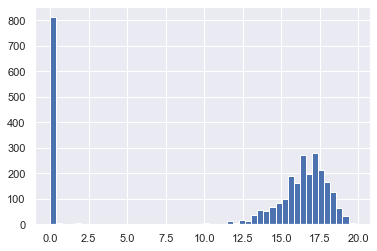

In [127]:
#Data Preprocessing & Distribtuion of Target Metric
data_raw['log_budget'] = np.log1p(data_raw['budget'])

na_target = data_raw[data_raw['log_budget'].isna()]
if na_target.shape[0]>=0:
    print(f'{na_target.shape[0]} records in data where target is NA \n')
    data_raw = data_raw.dropna(axis = 0, subset=['log_budget'])        
    %matplotlib inline
    data_raw['log_budget'].hist(bins=50)
    plt.show()

In [128]:
data_raw[['budget', 'clipped_budget','log_budget']].describe()

,budget,clipped_budget,log_budget
count,3000.00,3000.00,3000.00
mean,22531334.11,22437580.62,11.88
std,37026086.41,36592021.88,7.44
min,0.00,0.00,0.00
25%,0.00,250000.00,0.00
50%,8000000.00,8000000.00,15.89
75%,29000000.00,28475000.00,17.18
max,380000000.00,369500000.00,19.76


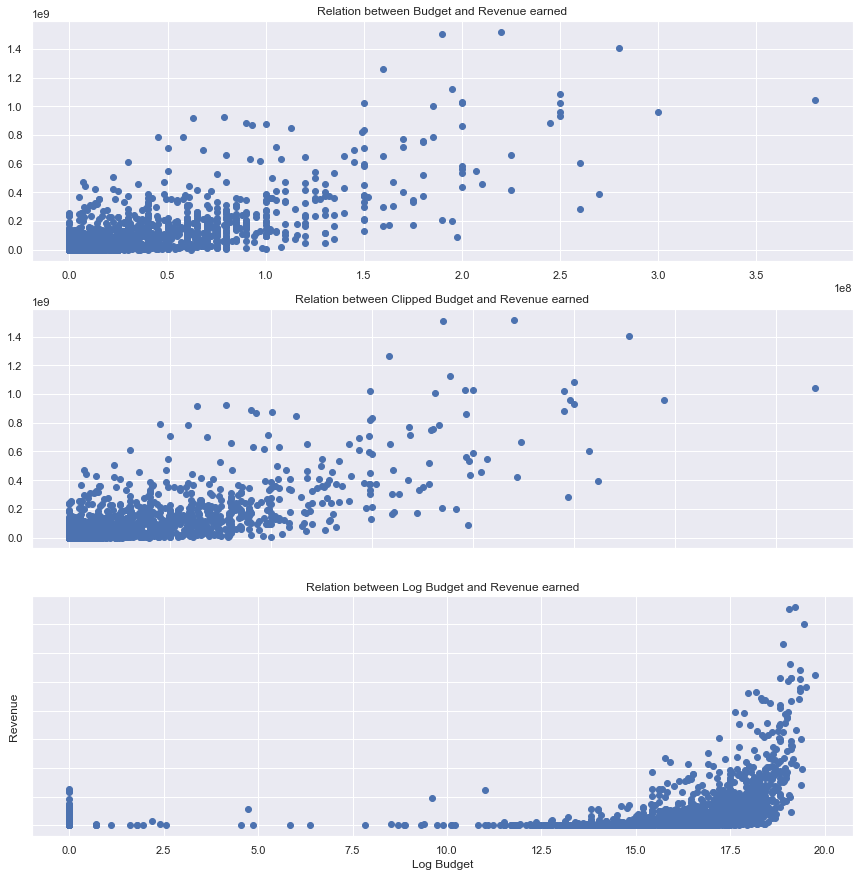

In [129]:
if script_run in ['retrain','retrain_with_gridsearch']:
    # Set up the axes with gridspec
    fig = plt.figure(figsize=(50, 15))
    grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)
    budget_plt = fig.add_subplot(grid[0,1])
    clipped_budget_plt = fig.add_subplot(grid[1, 1], xticklabels=[])
    log_budget_plt = fig.add_subplot(grid[2, 1], yticklabels=[])

    # scatter points on the Budget axes
    budget_plt.scatter(x=data_raw['budget'], y=data_raw['revenue'])
    budget_plt.set_title('Relation between Budget and Revenue earned')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')

    # scatter points on the Clipped Budget axes
    clipped_budget_plt.scatter(x=data_raw['clipped_budget'], y=data_raw['revenue'])
    clipped_budget_plt.set_title('Relation between Clipped Budget and Revenue earned')
    plt.xlabel('Clipped Budget')
    plt.ylabel('Revenue')

    # scatter points on the Log Budget axes
    log_budget_plt.scatter(x=data_raw['log_budget'], y=data_raw['revenue'])
    log_budget_plt.set_title('Relation between Log Budget and Revenue earned')
    plt.xlabel('Log Budget')
    plt.ylabel('Revenue')

# Feature Profiling

# Data PreProcessing
1. Imputations
2. Smalls Binning for categorical
3. Update Data Types

In [130]:
data_raw.head()

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,tagline,title,keywords,cast,crew,revenue,date,week,clipped_budget,log_budget
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.58,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2015-02-20,104788,13945000.00,16.45
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.25,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,2004-08-06,104240,40000000.00,17.50
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.30,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",...,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,2014-10-10,104769,3300000.00,15.01
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.17,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,...,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,2012-03-09,104634,1200000.00,14.00
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.15,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,...,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,2009-02-05,104474,0.00,0.00


### Feature: *Genres*

In [131]:
j = 0
data_raw['genre_Count'] = 0
for i in data_raw['genres']:
    d = get_dict(i)
    if d != {}:
        
        data_raw['genre_Count'][j] = len(d)
    else:
        data_raw['genre_Count'][j] = 0 
    j += 1
data_raw.drop(['genres'], axis=1, inplace=True)

### Feature: *Original_language*

<AxesSubplot:xlabel='original_language', ylabel='count'>

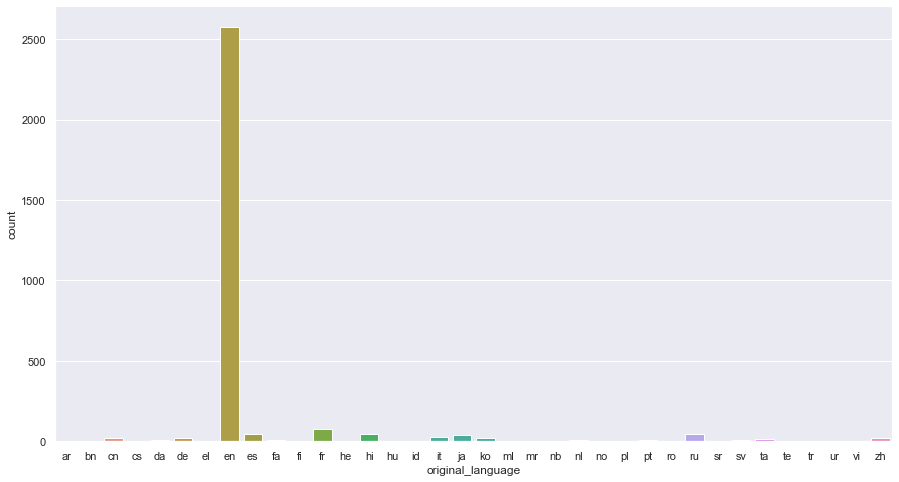

In [132]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(data_raw['original_language'].sort_values())

In [133]:
for i in data_raw['original_language']:
    if(i=='en'):
        data_raw['Has_En']=1
    else:
        data_raw['Has_En']=0
data_raw.drop(['original_language'], axis=1, inplace=True)

### Feature: *Popularity*

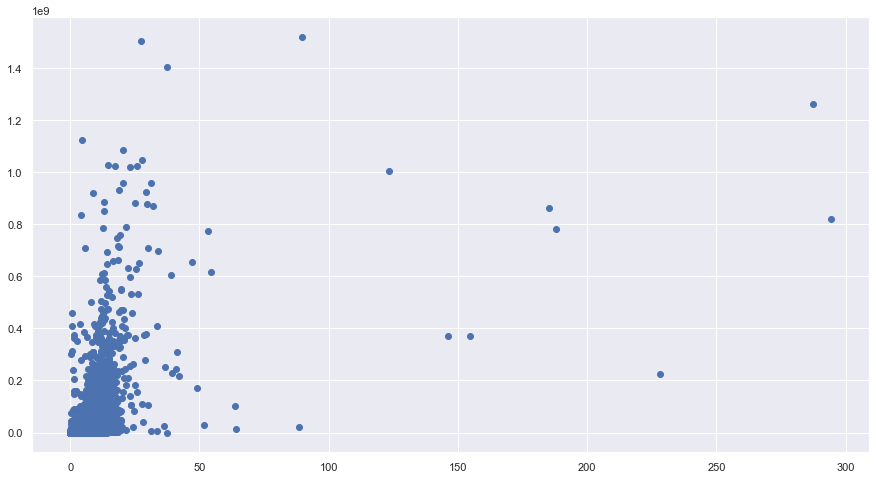

In [134]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.set(rc = {'figure.figsize':(15,8)})
    plt.scatter('popularity','revenue',data=data_raw)
    plt.show()

### Feature: *production_companies*

In [135]:
num_production_companies=pd.DataFrame(columns=['num_production_companies'])
data_raw=pd.concat([data_raw,num_production_companies],axis=1)

j=0
for i in data_raw["production_companies"]:
    d=get_dict(i)
    if len(d)!=0:
        data_raw['num_production_companies'][j]=len(d)
    else:
        data_raw['num_production_companies'][j]=np.NaN
    j+=1
data_raw.drop(['production_companies'], axis=1, inplace=True)

<AxesSubplot:xlabel='num_production_companies', ylabel='count'>

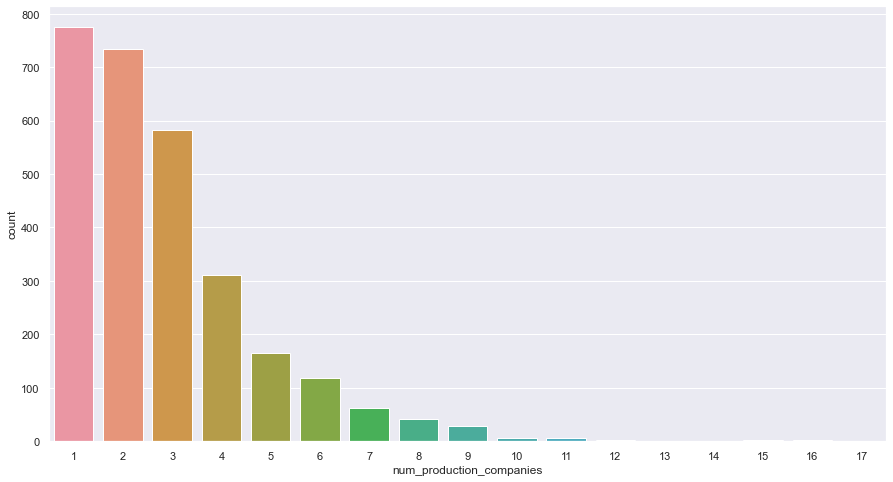

In [136]:
sns.countplot('num_production_companies',data=data_raw)

In [137]:
data_raw["num_production_companies"].isnull().sum()

156

In [138]:
data_raw['num_production_companies']=data_raw['num_production_companies'].fillna(data_raw['num_production_companies'].mean()).round()

### Feature: *production_countries*

In [139]:
prodect_countries=pd.DataFrame(columns=["production_country"])
data_raw=pd.concat([data_raw,prodect_countries],axis=1)

j = 0
for i in data_raw['production_countries']:
    d = get_dict(i)
    if d != {}:
        if len(d) > 1:
            countires = []
            for k in range(len(d)):
                countires.append(d[k]['name'])
            if 'United States of America' in countires:
                data_raw['production_country'][j] = 'United States of America'
        else:
            data_raw['production_country'][j] = d[0]['name']
    else:
        data_raw['production_country'][j] = np.NaN
    j += 1


In [140]:
is_use_preduction=pd.DataFrame(columns=["is_use_preduction"])
data_raw=pd.concat([data_raw,is_use_preduction],axis=1)

In [141]:
j=0
for i in data_raw["production_country"]:
    if i=='United States of America':
        data_raw['is_use_preduction'][j]=1
    elif str(i)=='NaN':
        data_raw['is_use_preduction'][j]=np.NaN
    else:
        data_raw['is_use_preduction'][j]=0
    j+=1
data_raw.drop(['production_countries','production_country'], axis=1, inplace=True)

In [142]:
data_raw['is_use_preduction'].isnull().sum()

0

### Feature: *release_data*

In [143]:
data_raw["release_year"] = pd.to_datetime(data_raw["release_date"]).dt.year.astype(int)
data_raw["release_day"] = pd.to_datetime(data_raw["release_date"]).dt.dayofweek.astype(int)
data_raw["release_month"] = pd.to_datetime(data_raw["release_date"]).dt.month.astype(int)

In [144]:
def fix_date(x):
    if x > 2022:
        return x - 100
    else:
        return x 

data_raw['release_year'] = data_raw['release_year'].apply(lambda x: fix_date(x))

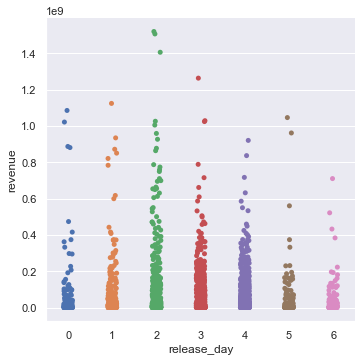

In [145]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x='release_day',y='revenue',data=data_raw)

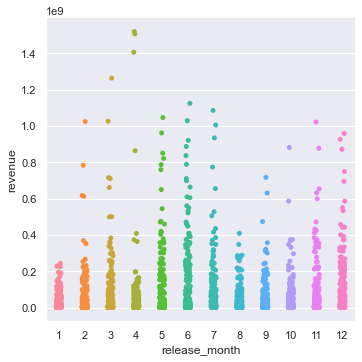

In [146]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x='release_month',y='revenue',data=data_raw)

(array([  17.,   17.,   29.,   45.,   67.,  142.,  379.,  605., 1016.,
         683.]),
 array([1924. , 1933.7, 1943.4, 1953.1, 1962.8, 1972.5, 1982.2, 1991.9,
        2001.6, 2011.3, 2021. ]),
 <BarContainer object of 10 artists>)

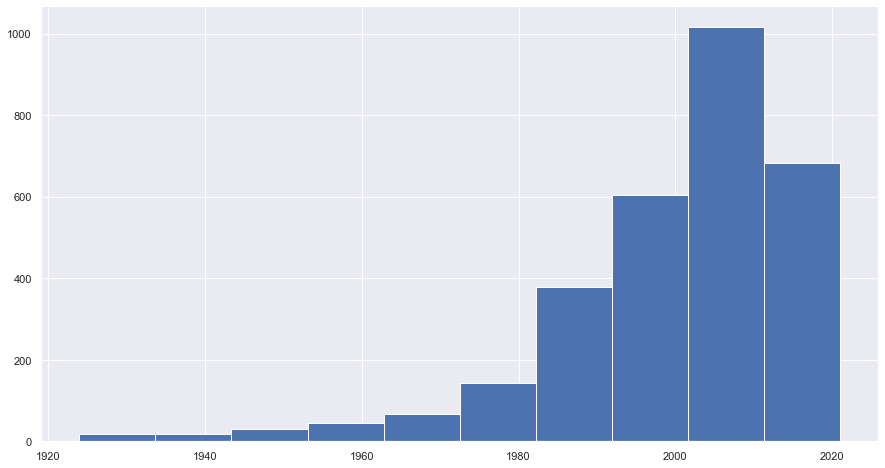

In [147]:
plt.hist('release_year',data=data_raw)

### Feature: *runtime*

In [148]:
data_raw['runtime'].isnull().sum()

2

In [149]:
data_raw['runtime']=data_raw['runtime'].fillna(data_raw['runtime'].mean()).round()

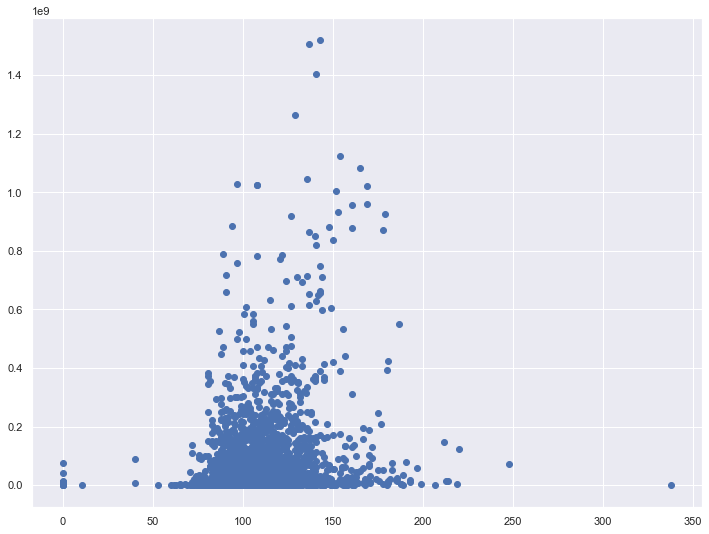

In [150]:
if script_run in ['retrain','retrain_with_gridsearch']:
    plt.subplots(figsize=(12, 9))
    plt.scatter('runtime','revenue',data=data_raw)

In [151]:
data_raw.head()

,id,budget,imdb_id,original_title,overview,popularity,poster_path,release_date,runtime,spoken_languages,...,week,clipped_budget,log_budget,genre_Count,Has_En,num_production_companies,is_use_preduction,release_year,release_day,release_month
0,1,14000000,tt2637294,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.58,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2015-02-20,93.00,"[{'iso_639_1': 'en', 'name': 'English'}]",...,104788,13945000.00,16.45,1,1,3.00,1,2015,4,2
1,2,40000000,tt0368933,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.25,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,2004-08-06,113.00,"[{'iso_639_1': 'en', 'name': 'English'}]",...,104240,40000000.00,17.50,4,1,1.00,1,2004,4,8
2,3,3300000,tt2582802,Whiplash,"Under the direction of a ruthless instructor, ...",64.30,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,2014-10-10,105.00,"[{'iso_639_1': 'en', 'name': 'English'}]",...,104769,3300000.00,15.01,1,1,3.00,1,2014,4,10
3,4,1200000,tt1821480,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.17,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,2012-03-09,122.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,104634,1200000.00,14.00,2,1,3.00,0,2012,4,3
4,5,0,tt1380152,마린보이,Marine Boy is the story of a former national s...,1.15,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,2009-02-05,118.00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",...,104474,0.00,0.00,2,1,3.00,0,2009,3,2


### Feature: *spoken_languages*

In [152]:
number_of_spoken_languages = pd.DataFrame(columns=['number_of_spoken_languages'])
data_raw = pd.concat([data_raw, number_of_spoken_languages], axis=1)

j = 0
for i in data_raw['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        data_raw['number_of_spoken_languages'][j] = len(d)
    else:
        data_raw['number_of_spoken_languages'][j] = np.NaN
    j += 1


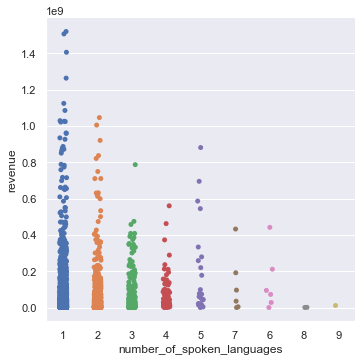

In [153]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x='number_of_spoken_languages', y='revenue', data=data_raw)

In [154]:
data_raw["number_of_spoken_languages"].isnull().sum()

20

In [155]:
data_raw['number_of_spoken_languages']=data_raw['number_of_spoken_languages'].fillna(data_raw['number_of_spoken_languages'].mean()).round()
data_raw.drop(['spoken_languages'], axis=1, inplace=True)

### Feature: *status*

In [156]:
data_raw['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [157]:
Status=pd.DataFrame(columns=["Status"])
data_raw=pd.concat([data_raw,Status],axis=1)

j=0
for i in data_raw["status"]:
    if i=='Released':
        data_raw['Status'][j]=1
    elif str(i)=='NaN':
        data_raw['Status'][j]=np.NaN
    else:
        data_raw['Status'][j]=0
    j+=1
data_raw.drop(['status'], axis=1, inplace=True)

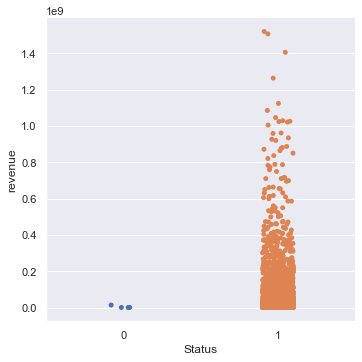

In [158]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x="Status",y="revenue",data=data_raw)

In [159]:
data_raw.drop(['Status'], axis=1, inplace=True)

### Feature: *tagline*

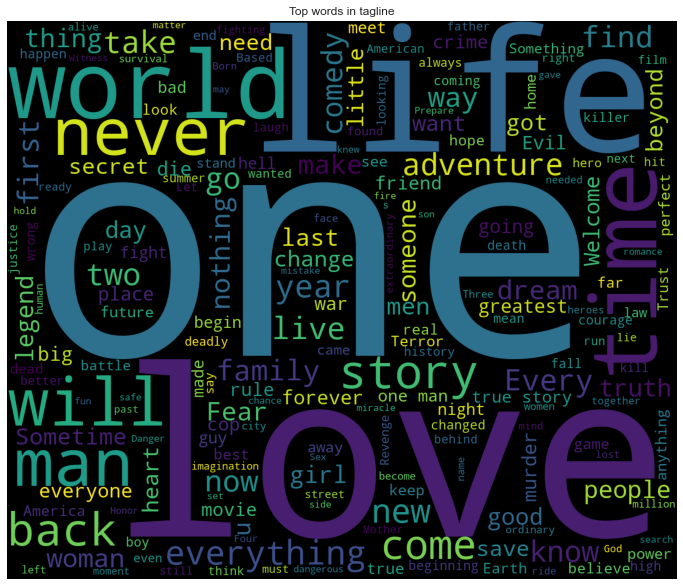

In [160]:
plt.figure(figsize = (12, 12))
text = ' '.join(data_raw['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

In [161]:
data_raw.drop(['title','release_date','tagline','date'], axis=1, inplace=True)

##  We can conclude that most films contains comedy, drama related words.

### Feature: *cast*

In [162]:
size_of_cast = pd.DataFrame(columns=['size_of_cast'])
data_raw = pd.concat([data_raw, size_of_cast], axis=1)

j = 0
for i in data_raw['cast']:
    d = get_dict(i)
    if d != {}:
        data_raw['size_of_cast'][j] = len(d)
    else:
        data_raw['size_of_cast'][j] = np.NaN
    j += 1
    
data_raw.drop(['cast'], axis=1, inplace=True)

In [163]:
data_raw["size_of_cast"].isnull().sum()

13

In [164]:
data_raw['size_of_cast']=data_raw['size_of_cast'].fillna(data_raw['size_of_cast'].mean()).round()

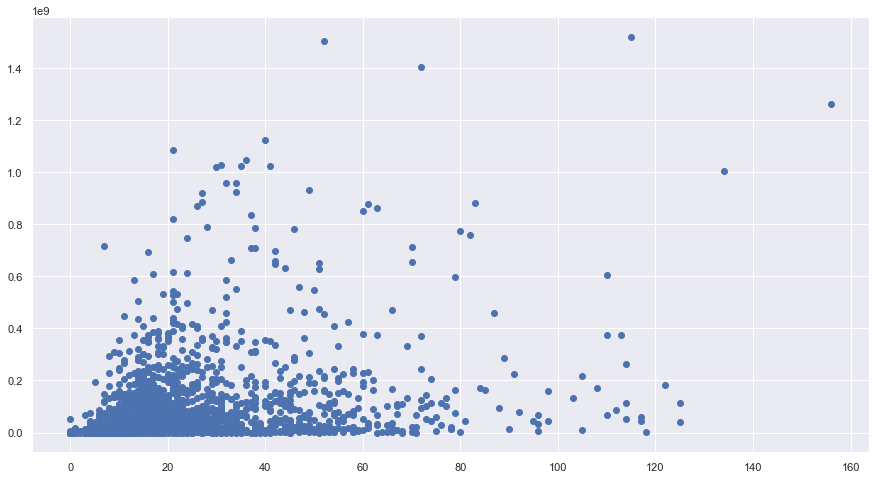

In [165]:
if script_run in ['retrain','retrain_with_gridsearch']:
    plt.scatter("size_of_cast","revenue",data=data_raw)

### Drop Features with No importance

In [166]:
features_to_remove_ls = ['poster_path','imdb_id','original_title','overview','keywords','crew','budget']
data_raw.drop(features_to_remove_ls, axis=1, inplace=True)

In [167]:
NULLsRecords = data_raw.isnull().sum(axis=0)
print(NULLsRecords[NULLsRecords>0])
max(NULLsRecords)

Series([], dtype: int64)


0

In [168]:
data_raw.head()

,id,popularity,runtime,revenue,week,clipped_budget,log_budget,genre_Count,Has_En,num_production_companies,is_use_preduction,release_year,release_day,release_month,number_of_spoken_languages,size_of_cast
0,1,6.58,93.00,12314651,104788,13945000.00,16.45,1,1,3.00,1,2015,4,2,1.00,24.00
1,2,8.25,113.00,95149435,104240,40000000.00,17.50,4,1,1.00,1,2004,4,8,1.00,20.00
2,3,64.30,105.00,13092000,104769,3300000.00,15.01,1,1,3.00,1,2014,4,10,1.00,51.00
3,4,3.17,122.00,16000000,104634,1200000.00,14.00,2,1,3.00,0,2012,4,3,2.00,7.00
4,5,1.15,118.00,3923970,104474,0.00,0.00,2,1,3.00,0,2009,3,2,1.00,4.00


# Feature Correlation

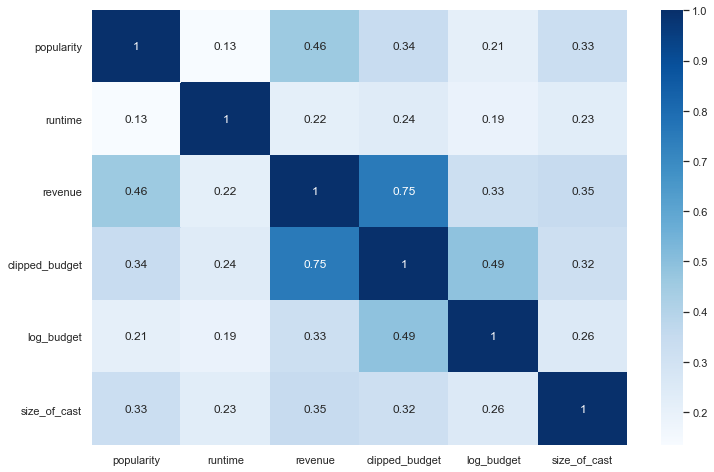

In [169]:
if script_run in ['retrain','retrain_with_gridsearch']:
    corr =data_raw.corr()
    top_feature = corr.index[abs(corr['revenue'])>0.2]
    #Correlation plot
    plt.subplots(figsize=(12, 8))
    top_corr = data_raw[top_feature].corr()
    sns.heatmap(top_corr,cmap='Blues', annot=True)
    plt.show()

In [170]:
os.getcwd()

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model'

In [171]:
if script_run in ['retrain','retrain_with_gridsearch']:
    Data_Files_ls = os.listdir(f'{os.getcwd()}/{program_name}/Results')
    for f in Data_Files_ls:
        if not f.startswith('.'):
            shutil.move(f'{os.getcwd()}/{program_name}/Results/{f}',f'{os.getcwd()}/{program_name}/Results_Old/{f}')

In [172]:
os.chdir(os.getcwd()+'/'+program_name+'/Results')
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d\\Results'

# Feature Profiling

In [173]:
continuous_type_ls = ['float16', 'float32', 'int16', 'int8','int64','float64','int32']
categorical_type_ls = ['object','category','UInt32']
trigger_cont_val = 0
trigger_cat_val = 0

cat_attribs = []
num_attribs =[]

for col in tqdm(data_raw.columns):
    if str(data_raw[col].dtype) in continuous_type_ls and trigger_cont_val<=15:
        num_attribs.append(col)
        trigger_cont_val = trigger_cont_val + 1
    if str(data_raw[col].dtype) in categorical_type_ls and trigger_cat_val<=15:
        cat_attribs.append(col)
        trigger_cat_val = trigger_cat_val + 1
print(num_attribs)
print(cat_attribs)

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7867.39it/s]

['id', 'popularity', 'runtime', 'revenue', 'clipped_budget', 'log_budget', 'genre_Count', 'Has_En', 'num_production_companies', 'release_year', 'release_day', 'release_month', 'number_of_spoken_languages', 'size_of_cast']
['week', 'is_use_preduction']


In [174]:
num_ls = [i for i in num_attribs if i not in ['release_month','id']]
cat_ls = [i for i in cat_attribs if i not in ['release_month','id']]
print(num_ls)
print(cat_ls)

['popularity', 'runtime', 'revenue', 'clipped_budget', 'log_budget', 'genre_Count', 'Has_En', 'num_production_companies', 'release_year', 'release_day', 'number_of_spoken_languages', 'size_of_cast']
['week', 'is_use_preduction']


2it [00:00,  3.20it/s]


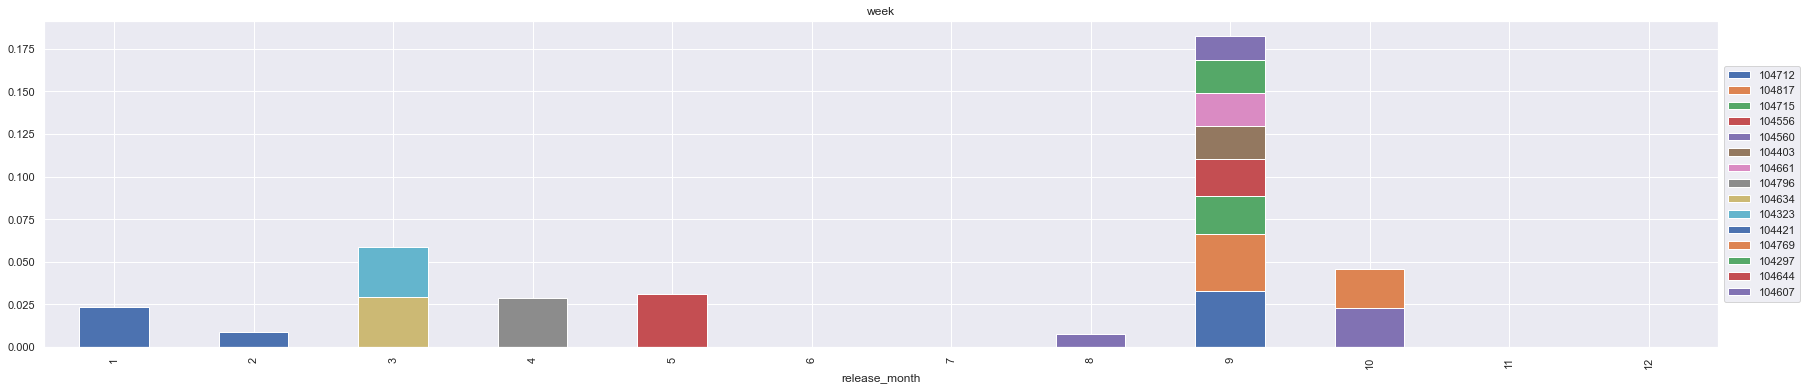

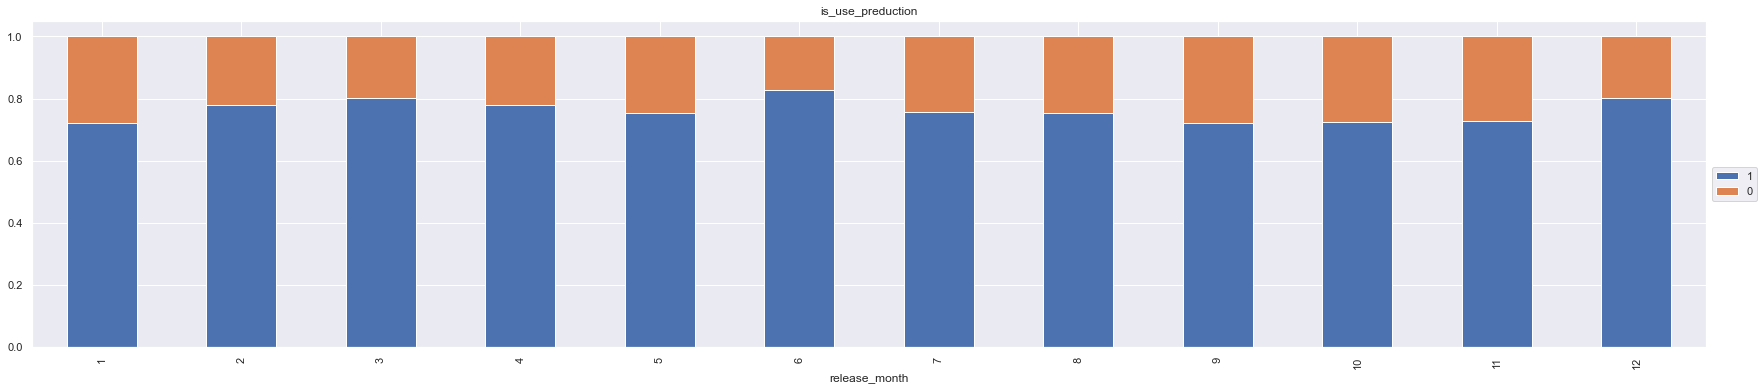

In [175]:
# categorical feature distributions

visual_train = data_raw.copy()
cat_report_pdf = PdfPages(f"Categorical_feature_profiling.pdf")
for i, col in tqdm(enumerate(cat_ls)):
    fig, axes = plt.subplots(1,1,sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(30)
    col_list = visual_train[col].value_counts(1).head(15).index
    a = (visual_train.groupby(['release_month',col])['release_month'].count()/visual_train.groupby(['release_month'])['release_month'].count()).unstack()[col_list].plot(kind='bar',stacked=True, ax=axes)
    axes.set_title(col)
    axes.legend(loc='center left',bbox_to_anchor=(1,0.5))
    cat_report_pdf.savefig(fig)
cat_report_pdf.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.41it/s]


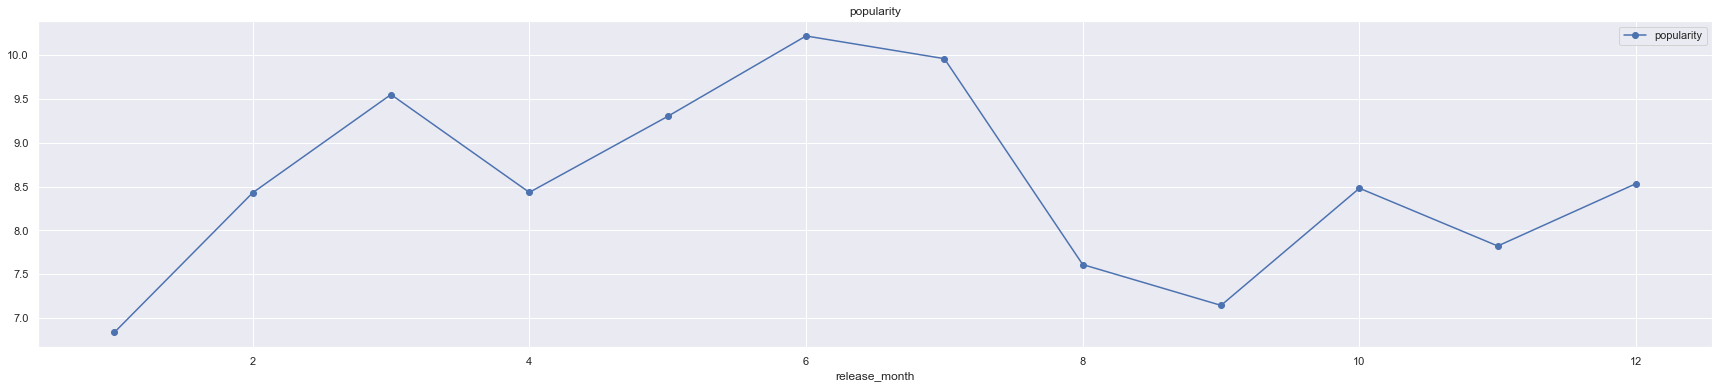

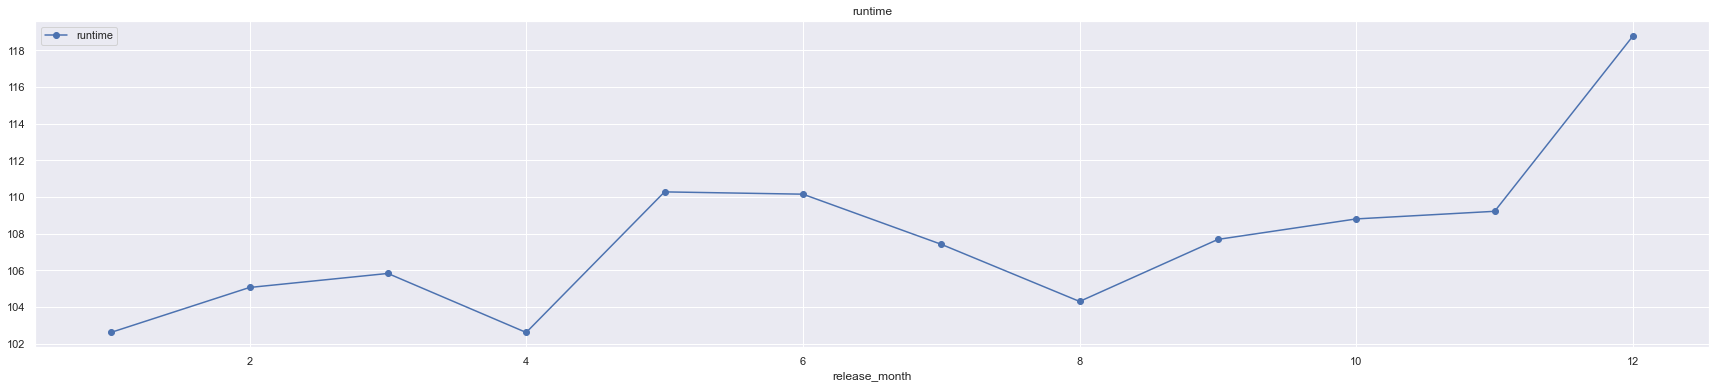

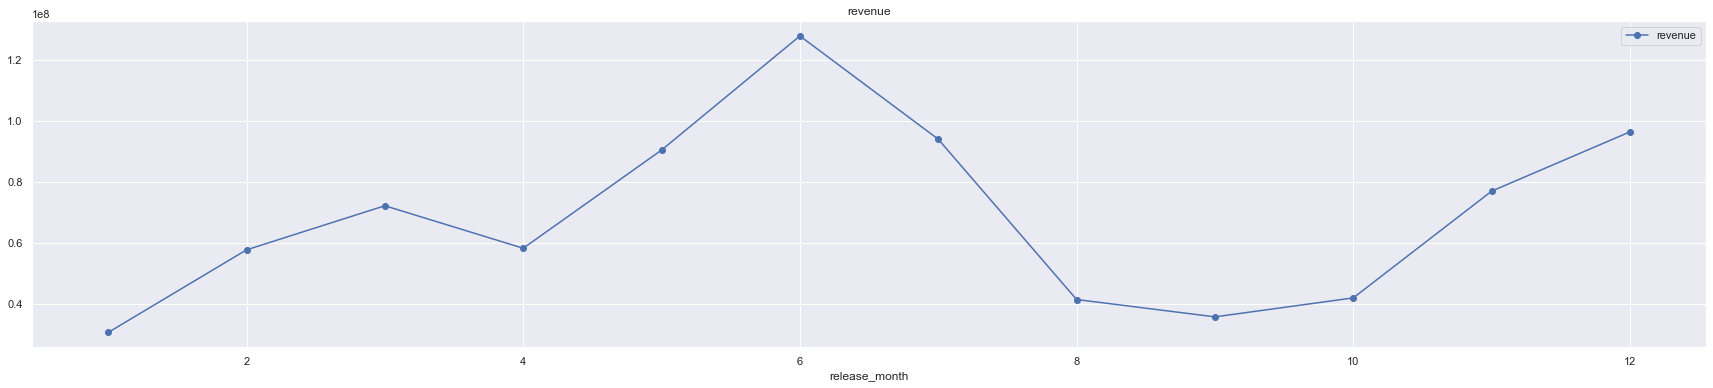

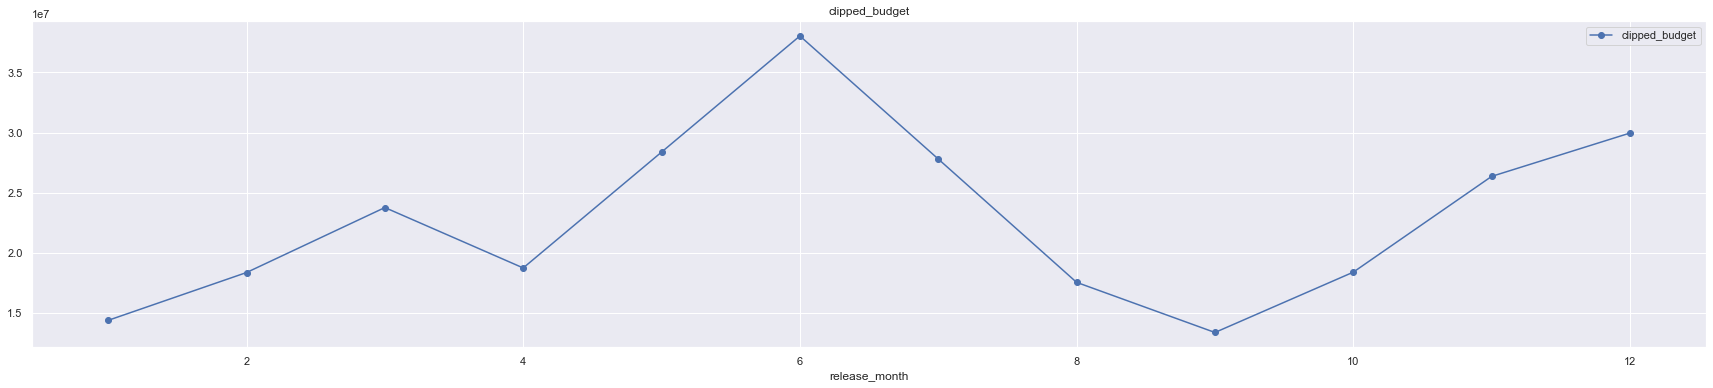

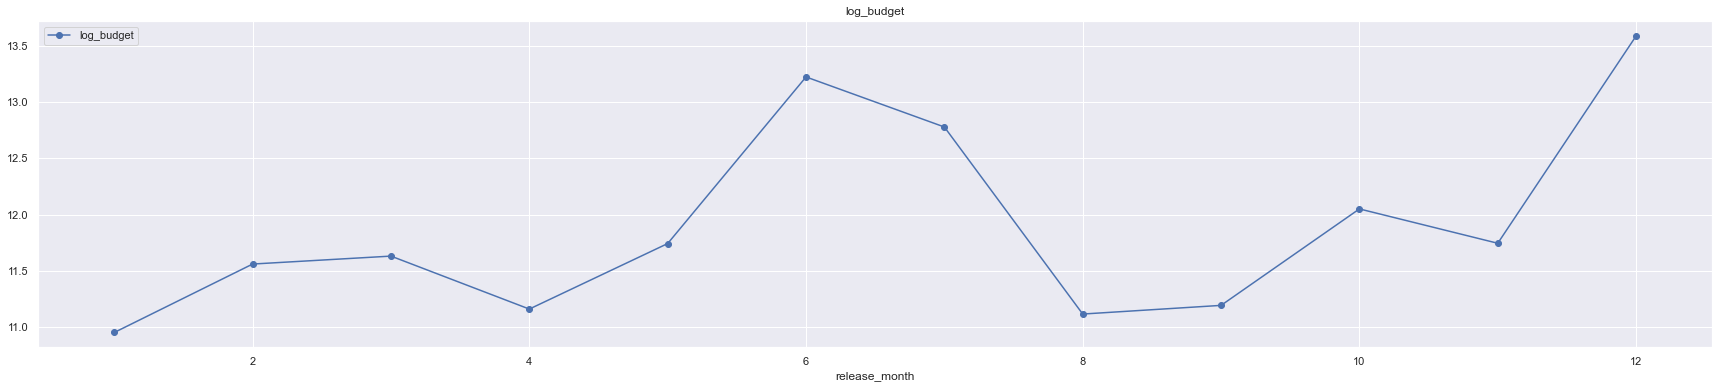

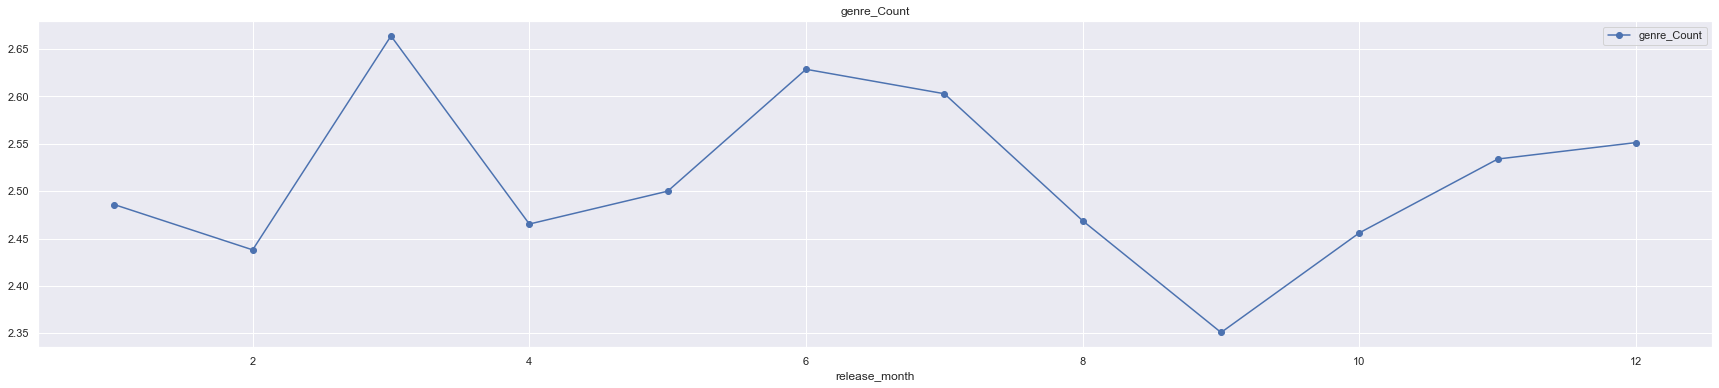

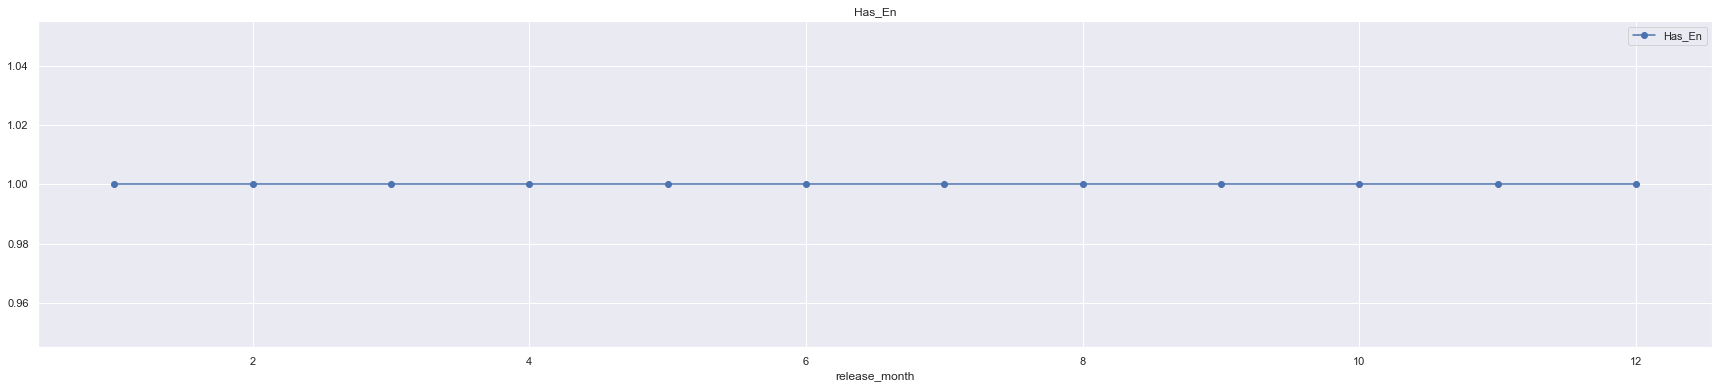

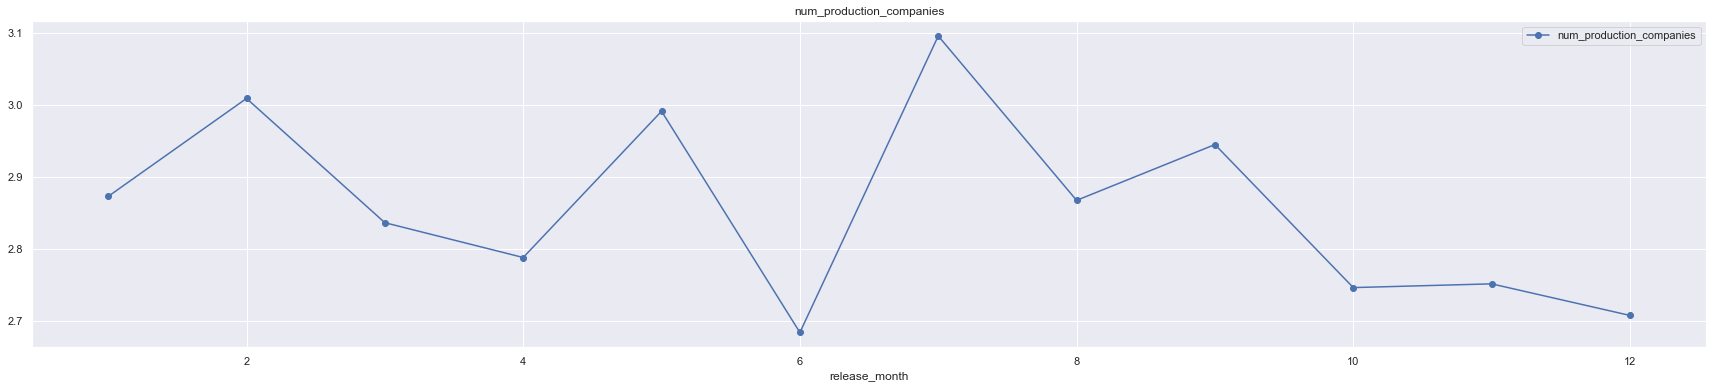

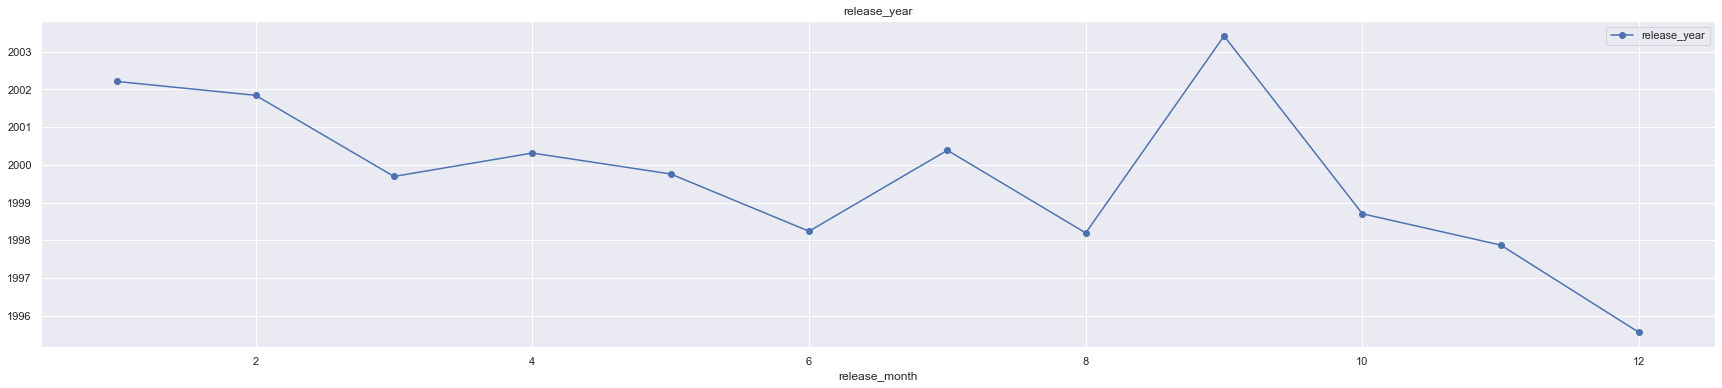

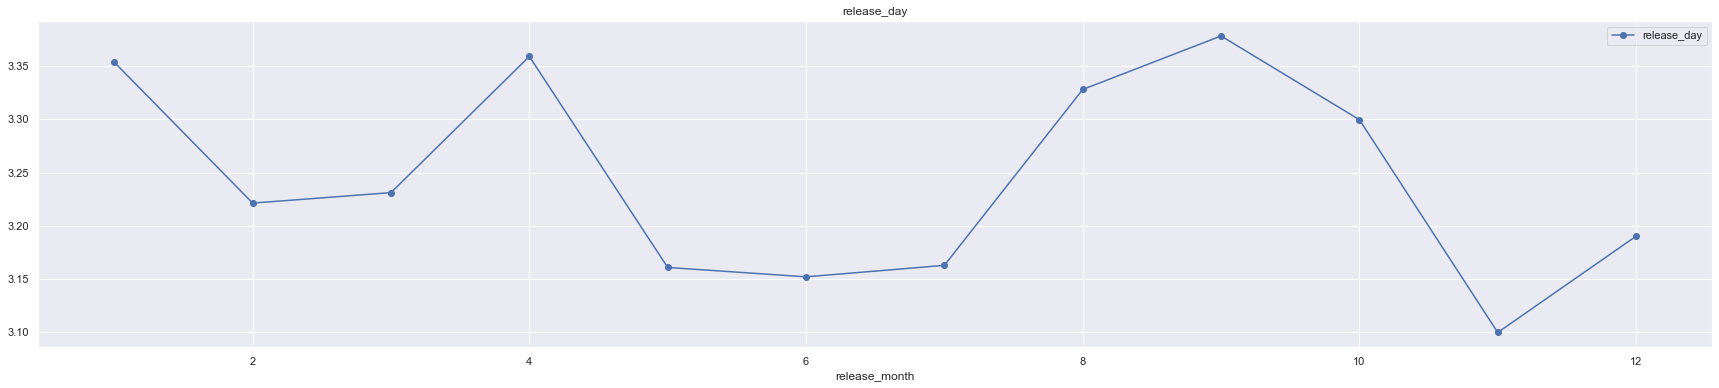

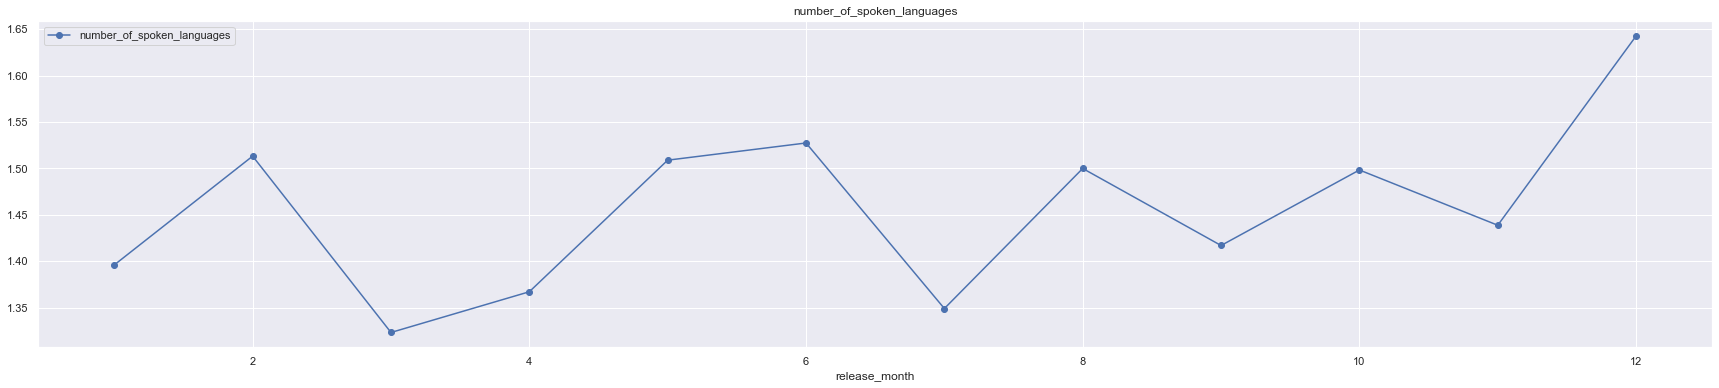

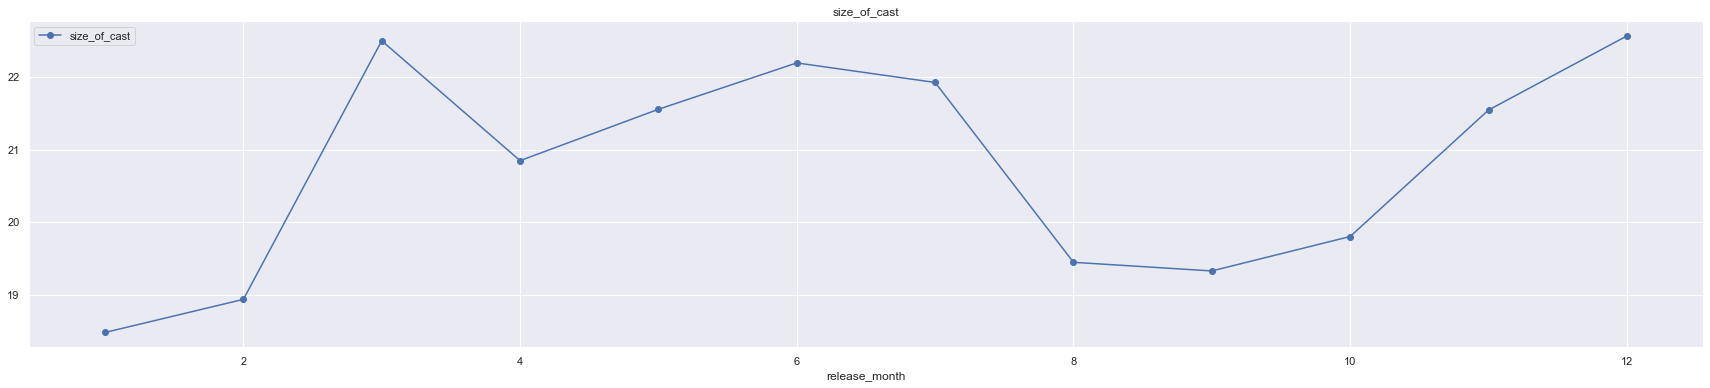

In [176]:
# continuous feature averages plots

cont_report_pdf = PdfPages(f"Continuous_feature_profiling.pdf")
for col in tqdm(num_ls):
    train_plot = visual_train[['release_month',col]].groupby(['release_month']).mean()
    fig, axes = plt.subplots(1,1,sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(30)
    a = train_plot.plot(title=col, ax=axes, marker = 'o')  
    cont_report_pdf.savefig(fig)
cont_report_pdf.close()

In [177]:
all_features_without_target_ls = [i for i in num_attribs + cat_attribs if i not in [target,'id']]
all_features_without_target_ls

['popularity',
 'runtime',
 'clipped_budget',
 'log_budget',
 'genre_Count',
 'Has_En',
 'num_production_companies',
 'release_year',
 'release_day',
 'release_month',
 'number_of_spoken_languages',
 'size_of_cast',
 'week',
 'is_use_preduction']

In [178]:
data_raw.columns

Index(['id', 'popularity', 'runtime', 'revenue', 'week', 'clipped_budget',
       'log_budget', 'genre_Count', 'Has_En', 'num_production_companies',
       'is_use_preduction', 'release_year', 'release_day', 'release_month',
       'number_of_spoken_languages', 'size_of_cast'],
      dtype='object')

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 5000 out of 5000 | elapsed:    6.4s finished


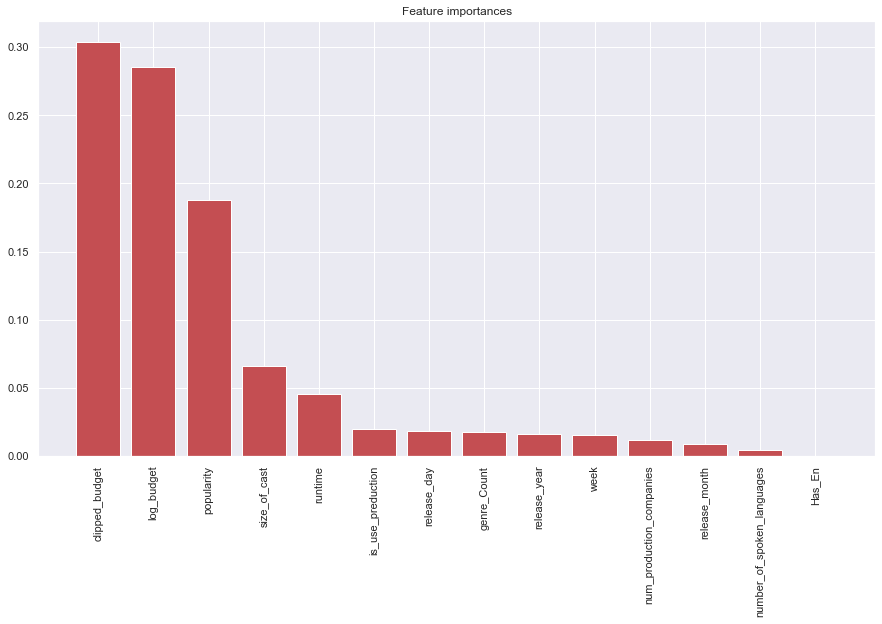

In [179]:
# Random Forrest feature importance
if script_run in ['retrain_with_gridsearch','retrain']:
    clf = RandomForestRegressor(n_estimators=5000,min_samples_split=0.02, max_features=0.2, random_state=0, n_jobs=5, verbose = 1)
    clf.fit(data_raw[all_features_without_target_ls],data_raw[target])

    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    values_ls = importances[indices]
    keys_ls = [all_features_without_target_ls[i] for i in indices]
    imp_feat_dict = dict(zip(keys_ls, values_ls))

    plt.figure()
    plt.title("Feature importances")

    plt.bar([all_features_without_target_ls[i] for i in indices], importances[indices],
           color="r", align="center")
    plt.xticks(rotation=90)
    plt.show()

In [180]:
if script_run in ['retrain_with_gridsearch','retrain']:
    final_feat_dict = dict((k, v) for k, v in imp_feat_dict.items() if v >= 0.01)
    final_feat_ls = list(final_feat_dict.keys())
    print(final_feat_ls)

['clipped_budget', 'log_budget', 'popularity', 'size_of_cast', 'runtime', 'is_use_preduction', 'release_day', 'genre_Count', 'release_year', 'week', 'num_production_companies']


# Transform Training Data - imputer, scaling, encoding

In [181]:
if script_run in ['retrain_with_gridsearch','retrain']:
    
    cat_attribs_FI = []
    num_attribs_FI =[]
    trigger_cont_val = 0
    trigger_cat_val = 0
    
    for col in tqdm(final_feat_ls):
        if str(data_raw[col].dtype) in continuous_type_ls and trigger_cont_val<=15:
            num_attribs_FI.append(col)
            trigger_cont_val = trigger_cont_val + 1
        if str(data_raw[col].dtype) in categorical_type_ls and trigger_cat_val<=15:
            cat_attribs_FI.append(col)
            trigger_cat_val = trigger_cat_val + 1
    print(num_attribs_FI)
    print(cat_attribs_FI)

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20905.00it/s]

['clipped_budget', 'log_budget', 'popularity', 'size_of_cast', 'runtime', 'release_day', 'genre_Count', 'release_year', 'num_production_companies']
['is_use_preduction', 'week']


In [182]:
#Pipeline - imputer, scaling, encoding
if script_run in ['retrain_with_gridsearch','retrain']:
    num_pipeline= Pipeline([
        ('Selector_num',DataFrameSelector(num_attribs_FI)),
        #('Imputer',SimpleImputer(strategy='median')),
        ('std_scalar', StandardScaler()),])

    cat_pipeline = Pipeline([
        ('Selector_cat',DataFrameSelector(cat_attribs_FI)),
        ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore')),])

    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline",num_pipeline),
        ("cat_pipeline",cat_pipeline)
    ])

In [183]:
os.chdir('..')
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d'

In [184]:
if script_run in ['retrain', 'retrain_with_gridsearch']:
    features_train = num_attribs_FI + cat_attribs_FI
    featurelist_file_name = f'{os.getcwd()}/Data_Files/{model_name}__featurelist.pkl'
    joblib.dump(features_train,featurelist_file_name, compress=1)
    old_file = featurelist_file_name
    new_file = f'{os.getcwd()}/Data_Files/{model_name_new}__featurelist.pkl'
    os.rename(old_file, new_file)
else:
    featurelist_file_name = f"{os.getcwd()}/Data_Files/{model_name}__featurelist.pkl"
    features_train = joblib.load(featurelist_file_name)

In [185]:
# if type_of_run != 'lookup':
#     X = data[features_train].copy()
#     Y = data[target].copy() 
    
if script_run in ['retrain_with_gridsearch','retrain']:
    X_train = data_raw[features_train].copy()
    Y_train = data_raw[target].copy() 
    X_train_prep = full_pipeline.fit_transform(X_train)
X = data_raw[features_train].copy()

# Feature Importance -  pick top K% features.

In [186]:
# Random Forrest feature importance
if script_run in ['retrain_with_gridsearch','retrain']:
    
    if(targettype == 'continuous'):
        clf = RandomForestRegressor(n_estimators=5000,min_samples_split=0.02, max_features=0.33, random_state=0, n_jobs=10, verbose = 1)
        clf.fit(X_train_prep,Y_train)

        importances = clf.feature_importances_
        cat_encoder = cat_pipeline.named_steps["cat_encoder"]
        cat_one_hot_attribs = list(cat_encoder.get_feature_names(cat_attribs_FI))
        attributes = num_attribs_FI + cat_one_hot_attribs

        importance_list = sorted(zip(importances,attributes), reverse=True)
        indices = np.argsort(importances)[::-1]
        sorted_importance = list(importances[indices])
        sorted_attributes = [attributes[i] for i in indices]
        sorted_importance = np.array(sorted_importance)
        threshold = np.percentile(sorted_importance,100-top_k)
        
        print(threshold)
        print('\n')
        
        index = [i for i,v in enumerate(importances) if v>threshold]
        print(index)
        print('\n')
        print(len(index))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:   15.7s
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:   19.6s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   19.7s finished


3.222767679766574e-09


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 140, 143, 144, 148, 149, 150, 151, 152, 156, 157, 158, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 178, 179, 182, 183, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 202, 204, 205, 206, 207, 209, 210, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 257, 258, 259, 260, 261, 262, 263, 265, 267, 269, 270, 271, 272, 273, 275, 276, 279, 280, 281, 282, 283,

In [187]:
if script_run in ['retrain_with_gridsearch','retrain']:
    full_pipeline_with_featureselection = Pipeline([
        ("data_prep",full_pipeline),
        ("feature_selection",TopFeatureSelector(importances,round(len(importances)*top_k/100)))])
    print(round(len(importances)*top_k/100))

1205


# Model Search 

In [188]:
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d'

In [189]:
best_params = 'Empty'
if script_run in ['retrain_with_gridsearch']:
    X_train_prep = full_pipeline_with_featureselection.fit_transform(X_train)
    print(X_train_prep.shape)
    
    reg_gs = GridSearchCV(estimator=XGBRegressor(),
                      param_grid={"eta": (0.01,0.05,0.1,0.15),
                                  "max_depth": [4,8,10,11,13,16],
                                  "min_child_weight": [1],
                                  "gamma": [0.0, 0.3,0.5,0.7,0.9,1.1,1.3,1.5],
                                  "colsample_bytree": [0.3, 0.5,0.6, 0.7, 1.0],}, 
                       cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=10)
    grid_result = reg_gs.fit(X_train_prep, Y_train)
    best_params = grid_result.best_params_
    #print(grid_result.cv_results_)
    print(grid_result.best_score_)
    print(best_params)
    joblib.dump(best_params,f'{os.getcwd()}/Data_Files/best_xgboost_{last_trained_model_date}.pkl', compress=1)
    
    old_file = os.path.join(f'{os.getcwd()}/Data_Files/',"best_xgboost_"+last_trained_model_date+".pkl")
    new_file = os.path.join(f'{os.getcwd()}/Data_Files/','best_xgboost_'+today_trained_model_date+".pkl")
    os.rename(old_file, new_file)
if script_run in ['retrain']:
    print('GS Skipped')
    best_params = joblib.load(f'{os.getcwd()}/Data_Files/best_xgboost_{last_trained_model_date}.pkl')
    old_file = os.path.join(f'{os.getcwd()}/Data_Files/',"best_xgboost_"+last_trained_model_date+".pkl")
    new_file = os.path.join(f'{os.getcwd()}/Data_Files/','best_xgboost_'+today_trained_model_date+".pkl")
    os.rename(old_file, new_file)
else:
    print('GS Skipped')
    best_params = joblib.load(f'{os.getcwd()}/Data_Files/best_xgboost_{last_trained_model_date}.pkl')
    print(best_params) 

GS Skipped


In [196]:
if other_models:
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, Y_train, test_size=.2, random_state=7)
    reg = LazyRegressor(predictions=True)
    multiple_models, multiple_predictions = reg.fit(X_train_1, X_test_1, y_train_1, y_test_1)
    print(multiple_models)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  4.07it/s]

                               Adjusted R-Squared  R-Squared          RMSE  \
Model                                                                        
GradientBoostingRegressor                    0.69       0.69   82202414.68   
HistGradientBoostingRegressor                0.68       0.68   83266432.68   
LGBMRegressor                                0.67       0.68   83838933.65   
OrthogonalMatchingPursuitCV                  0.67       0.68   84336056.20   
Lasso                                        0.67       0.67   84579246.04   
TransformedTargetRegressor                   0.67       0.67   84579246.08   
LinearRegression                             0.67       0.67   84579246.08   
Lars                                         0.67       0.67   84579246.08   
LassoLars                                    0.67       0.67   84579249.19   
KernelRidge                                  0.67       0.67   84583273.83   
Ridge                                        0.67       0.67   8

In [644]:
if script_run in ['retrain', 'retrain_with_gridsearch']:
    prep_predict_pipeline = Pipeline([
        ('prep_shortlist',full_pipeline_with_featureselection),
        ('xgb',XGBRegressor(**best_params))])
    prep_predict_pipeline.fit(X_train,Y_train)
    model_file_name = f'{os.getcwd()}/Data_Files/{model_name}__xgb_model.pkl'
    joblib.dump(prep_predict_pipeline,model_file_name, compress=1)
    old_file = model_file_name
    new_file = f'{os.getcwd()}/Data_Files/{model_name_new}__xgb_model.pkl'
    os.rename(old_file, new_file)
else:
    model_file_name = f'{os.getcwd()}/Data_Files/{model_name}__xgb_model.pkl'
    prep_predict_pipeline = joblib.load(model_file_name)

In [645]:
y_pred  = prep_predict_pipeline.predict(X)
y_pred = y_pred.round(1)
if script_run in ['retrain', 'retrain_with_gridsearch']:
    Y = data_raw[target]

60735676.41740986
0.8049154141211536


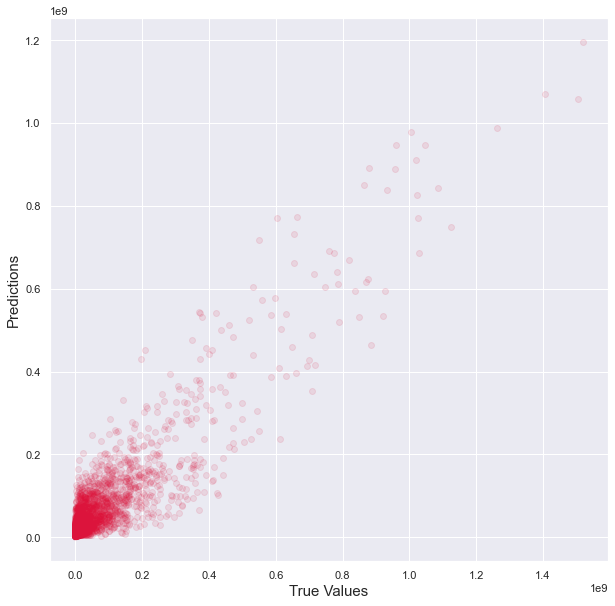

In [646]:
if script_run in ['retrain', 'retrain_with_gridsearch']:
    plt.figure(figsize=(10,10))
    plt.scatter(Y, y_pred, c='crimson',alpha=0.1)
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    print(np.sqrt(mean_squared_error(Y, y_pred)))
    print(r2_score(Y,y_pred))

In [647]:
u_ids = pd.DataFrame(data_raw[list(set(unique_identifier+['release_month']))])
pred  = pd.DataFrame(y_pred)
data_pred = pd.concat([u_ids.reset_index(drop = True), pred], axis = 1)
if script_run in ['retrain', 'retrain_with_gridsearch']:
    actual  = pd.DataFrame(Y)
    data_actual = pd.concat([u_ids.reset_index(drop = True), actual.reset_index(drop = True)], axis = 1)
    predictions = pd.merge(data_pred, data_actual, on =  ['id','release_month'], how = 'inner')
    predictions = predictions.rename(columns = {0:'prediction', target :'actual'})

In [648]:
os.chdir(os.getcwd()+'/Results')
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d\\Results'

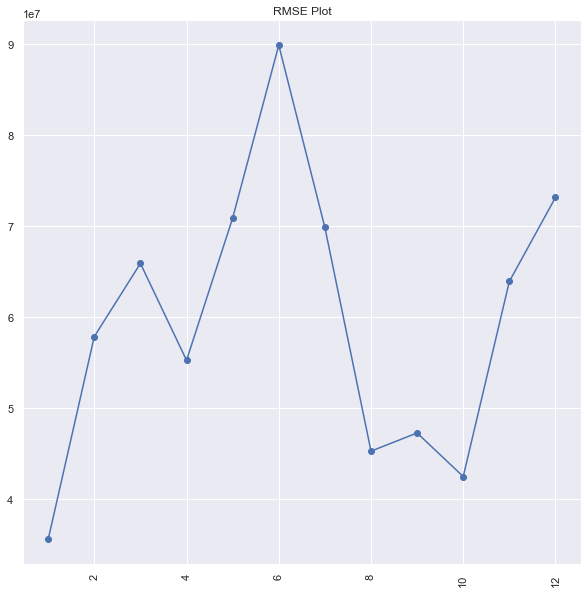

In [649]:
if script_run in ['retrain','retrain_with_gridsearch']:
    filename = script_run +"_Error_Plot_" + model_name_new +'.pdf'
    pdf = PdfPages(filename)    
    u_ids = pd.DataFrame(data_raw[list(set(unique_identifier+['release_month']))])
    pred  = pd.DataFrame(y_pred)
    actual  = pd.DataFrame(Y)

    predictions['inserted_date'] = pd.to_datetime('now')
    error = predictions.groupby(['release_month']).apply(lambda x: np.sqrt(mean_squared_error(x.actual,x.prediction))).reset_index()
    error.columns = ['release_month','rmse']
    fig_1 = plt.figure(figsize=(10,10))
    plt.plot(error['release_month'],error['rmse'],'-bo')
    plt.title('RMSE Plot')
    plt.xticks(rotation='90')
    pdf.savefig(fig_1)
    
    r2_sqr = predictions.groupby(['release_month']).apply(lambda x: np.sqrt(r2_score(x.actual,x.prediction))).reset_index()
    r2_sqr.columns = ['release_month','r2']
    fig_2 = plt.figure(figsize=(10,10))
    plt.plot(r2_sqr['release_month'],r2_sqr['r2'],'-bo')
    plt.title('R2 Square Plot')
    plt.xticks(rotation='90')
    pdf.savefig(fig_2)
    plt.close()
    pdf.close()
    
else:
    u_ids = pd.DataFrame(data_raw[list(set(unique_identifier+['release_month']))])
    pred  = pd.DataFrame(y_pred)
    predictions = pd.concat([u_ids,pred], axis=1)
    predictions.columns  = list(set(unique_identifier+['release_month']))+['prediction']
    predictions['inserted_date'] = pd.to_datetime('now')
    pred_raw_final = pd.merge(pred_raw, predictions, on =  ['id'], how = 'inner')
    filename_csv = script_run +'__'+ model_name + '_'+str(pd.to_datetime('now'))
    filename_csv = filename_csv.replace('.', '_').replace(' ','_').replace(':','_')
    filename_csv = filename_csv + '.csv'
    pred_raw_final.to_csv(filename_csv)

In [650]:
if script_run in ['retrain','retrain_with_gridsearch']:
    Zscores =stats.zscore(error['rmse'])
    indexes = (np.abs(Zscores)>2.0)
    anaomlousdays  = error[indexes]
    print(anaomlousdays)

   release_month          rmse
5              6  8.985418e+07


# Try & Test Models

In [651]:
# Rf_model=RandomForestRegressor(random_state=1)
# Rf_model.fit(train_x,y)
# Rf_prediction=Rf_model.predict(train_x)
# mean_absolute_error(Rf_prediction,y)

# r2_score(Rf_prediction,y)

# test_id=testData["id"]
# test_id.shape
# test_x=testData[features]
# Rf_predictions=Rf_model.predict(test_x)


# submission = pd.DataFrame({'id': test_id, 'revenue':Rf_predictions})
# submission = submission[['id', 'revenue']]

# submission.to_csv("submission.csv", index=False)